In [123]:
#| default_exp activations

# Activation stats

In [124]:
!python --version

Python 3.10.8


In [125]:
!pip install torcheval -qq

In [126]:
!pip install dc_stat_think -qq

In [127]:
#|export
from __future__ import annotations
import random,math,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset

from miniai.datasets import *
from miniai.learner import *

In [128]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [129]:
torch.__version__

'1.12.1'

In [130]:
#|export
def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [131]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

## Baseline

In [132]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

We want to train quickly, so that means training at a high learning rate.

In [133]:
from torcheval.metrics import MulticlassAccuracy

In [134]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [135]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

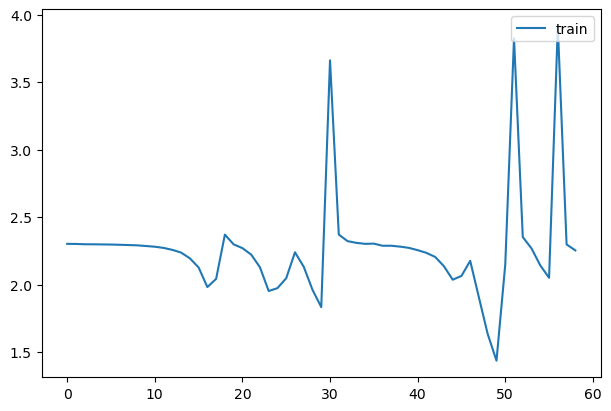

In [136]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

### Manual insertion

In [137]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        self.act_meds = [[] for _ in layers] # add medians
        self.acts = [[] for _ in layers] # add raw values for the activations
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds [i].append(to_cpu(x).std ())
            self.act_meds [i].append(to_cpu(x).median())
            self.acts[i].append(to_cpu(x).flatten())
        return x
    
    def __iter__(self): return iter(self.layers)

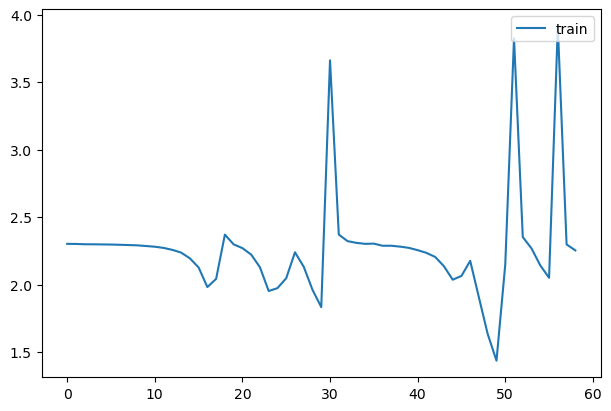

In [138]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

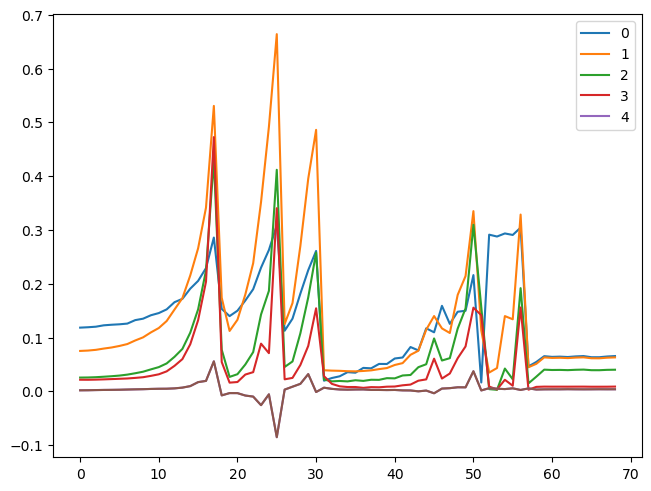

In [139]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

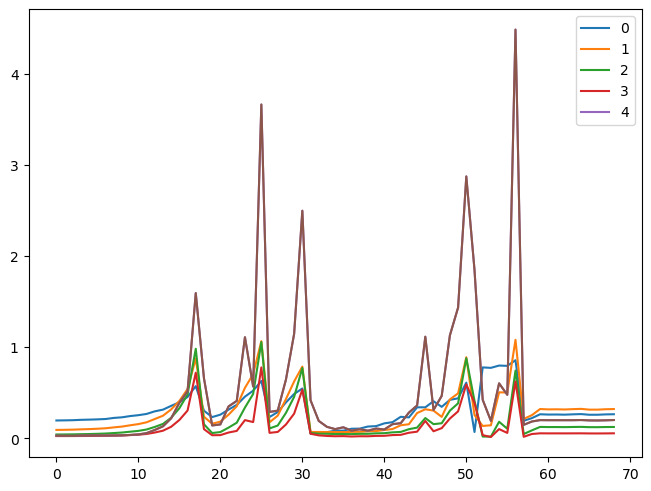

In [140]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

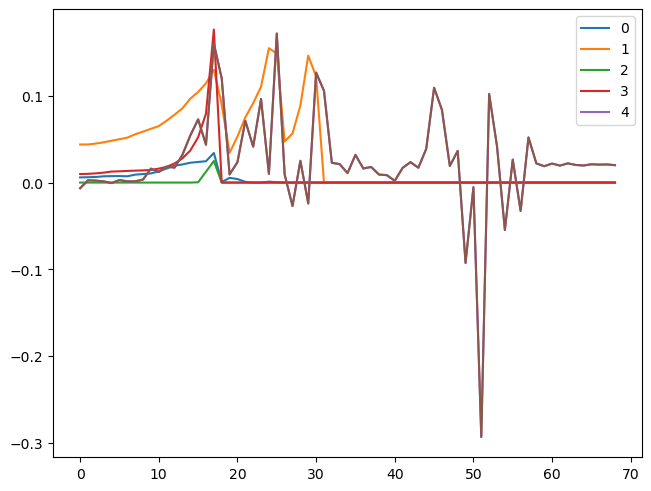

In [141]:
for l in model.act_meds: plt.plot(l)
plt.legend(range(5)); # not easy to interpret like the previous ones.

In [142]:
!pip install numba -qq

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model.

In [143]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [144]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]
act_meds = [[] for _ in model] # for storing the median values

In [145]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())
    act_meds [i].append(to_cpu(outp).median()) # implementation

In [146]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

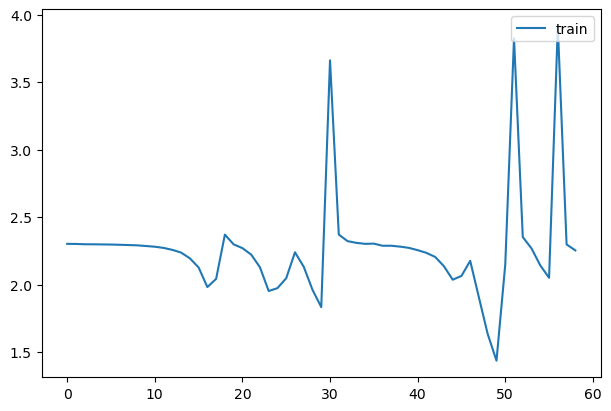

In [147]:
fit(model)

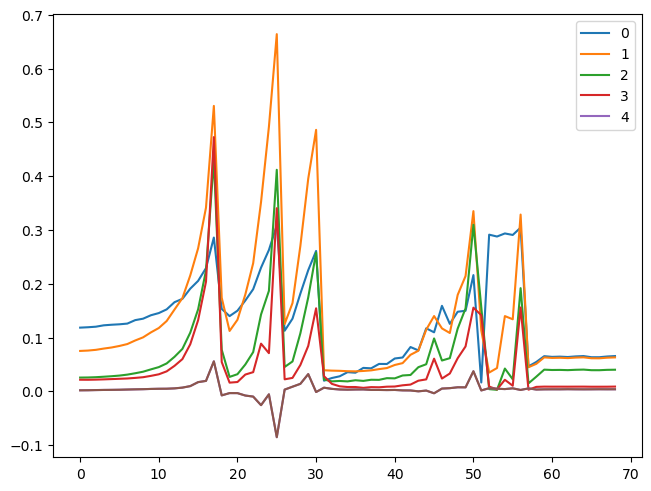

In [148]:
for o in act_means: plt.plot(o) 
plt.legend(range(5));

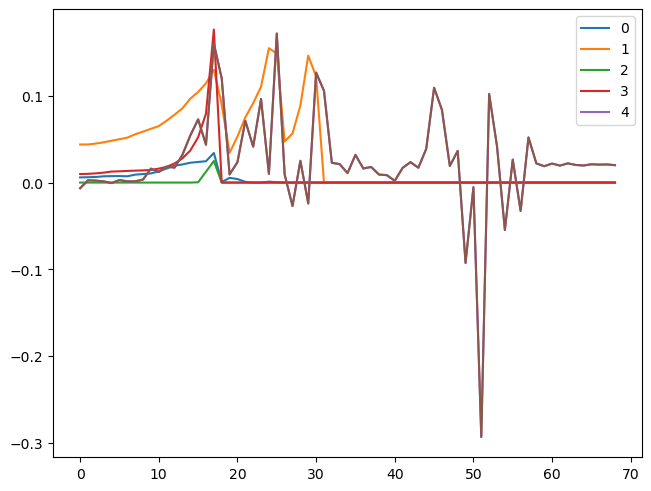

In [149]:
for p in act_meds: plt.plot(p)
plt.legend(range(5));

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [150]:
#| export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [151]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.median()) # ??

In [152]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [153]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

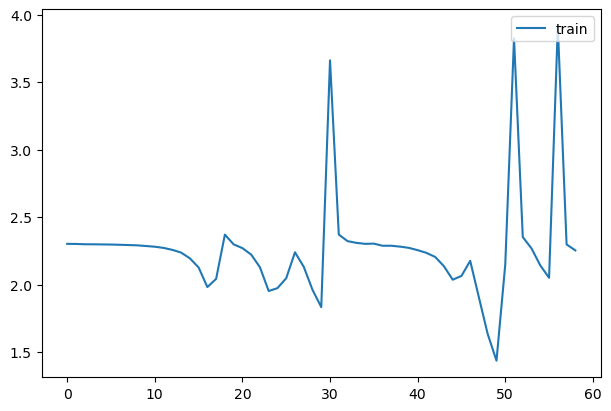

In [154]:
learn = fit(model)

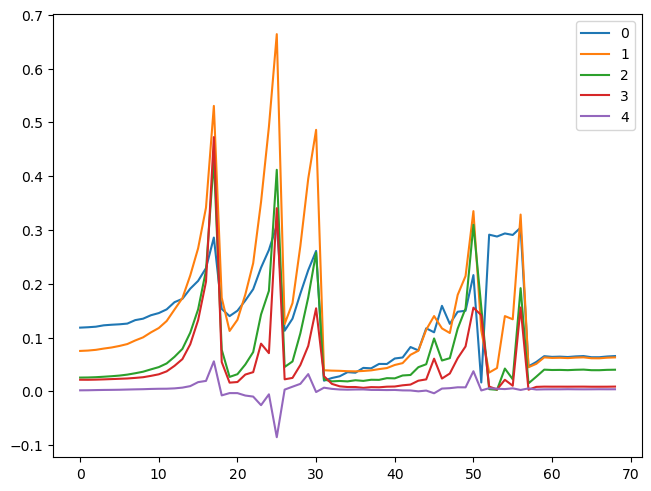

In [155]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

### A Hooks class

In [156]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    def __exit__ (self, *args): print("all done!")
    def hello(self): print("hello.")

In [157]:
with DummyCtxMgr() as dcm: dcm.hello()

let's go!
hello.
all done!


In [158]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)

In [159]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

In [160]:
del(dml[2])
dml

Say bye to item 2


[1, 3]

In [161]:
#| export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [162]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

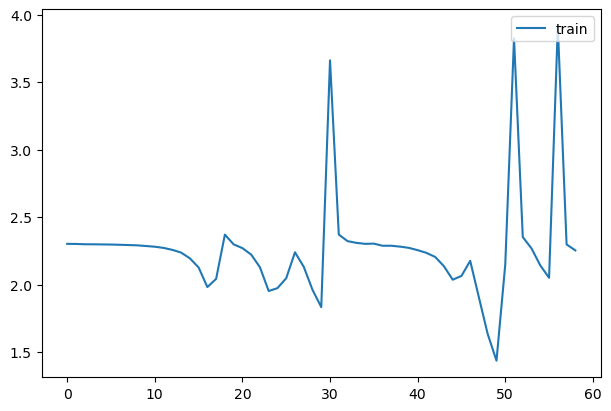

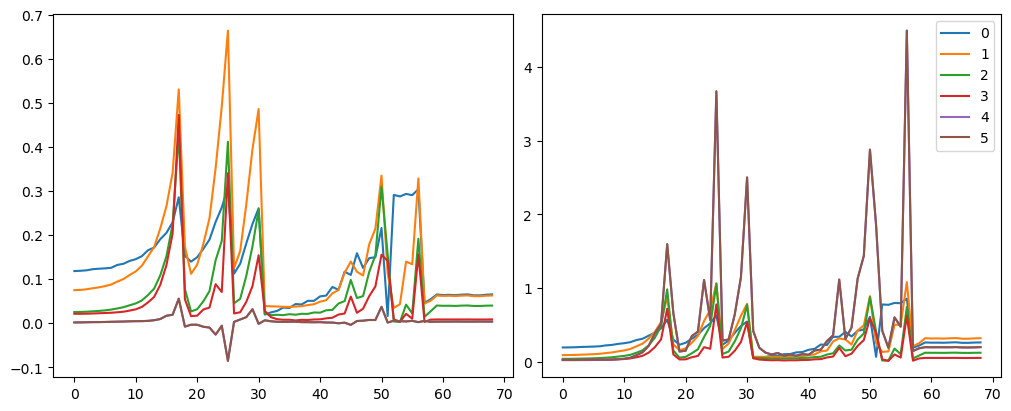

In [163]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### HooksCallback

In [164]:
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self):
        mods = fc.filter_ex(self.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, self._hookfunc)

    def _hookfunc(self, *args, **kwargs):
        if self.training: self.hookfunc(*args, **kwargs)

    def after_fit(self): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [165]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

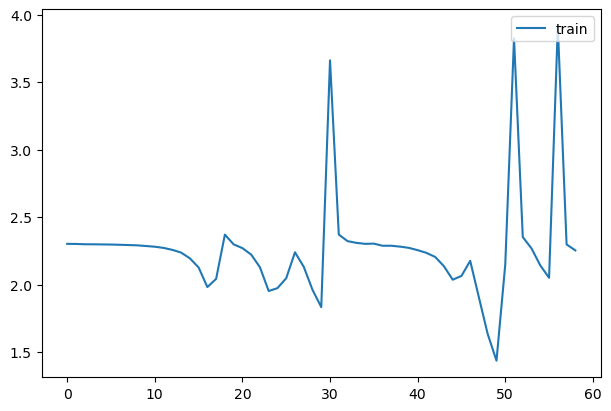

In [166]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

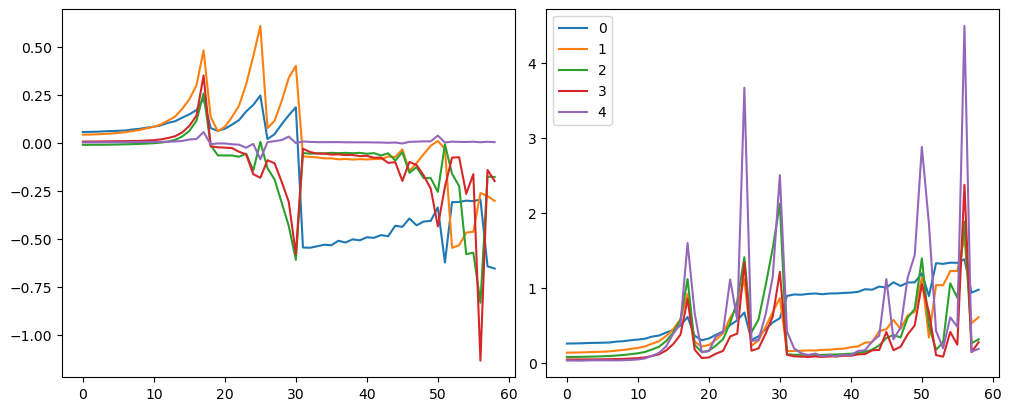

In [167]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

## Histograms

In [168]:
#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[]) # add list for raw activations
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))
    #hook.stats[3].append(acts.abs()) # add this to append the raw activations

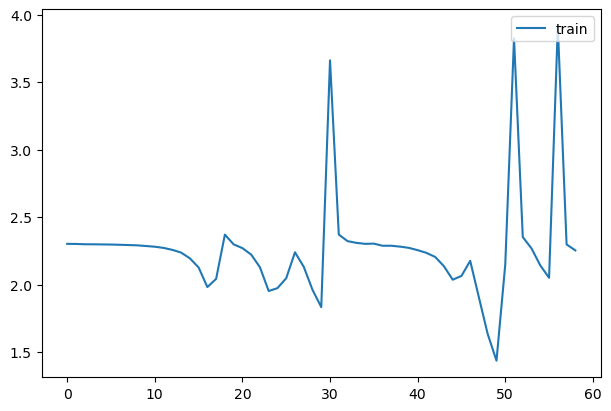

In [169]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [170]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

In [201]:
len(h.stats[2])

59

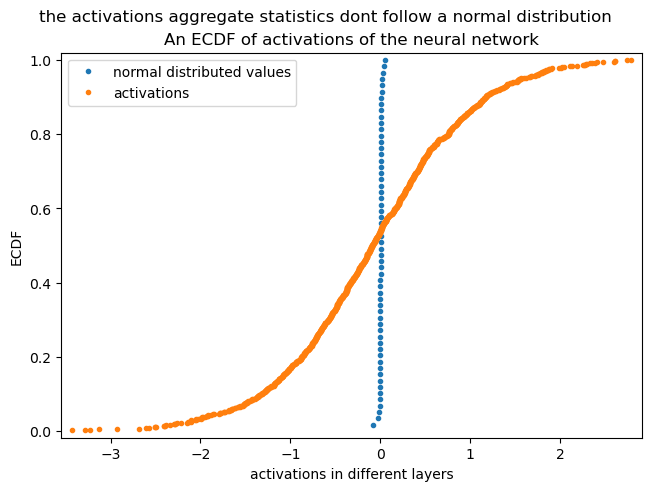

In [231]:
x,y = ecdf(h.stats[0])
x_exp, y_exp = ecdf(torch.randn(1000, dtype=torch.float))

# Generate plot
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.plot(x_exp, y_exp, marker = '.', linestyle = 'none')
                    
# Make the margins nice
plt.margins(0.02)

# Label the axes
plt.legend(('normal distributed values', 'activations'), loc='upper left')
plt.suptitle('the activations aggregate statistics dont follow a normal distribution')
_ = plt.xlabel("activations in different layers")
_ = plt.ylabel("ECDF")
_ = plt.title("An ECDF of activations of the neural network")

# Display the plot
plt.show()


In [ ]:
#| export
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

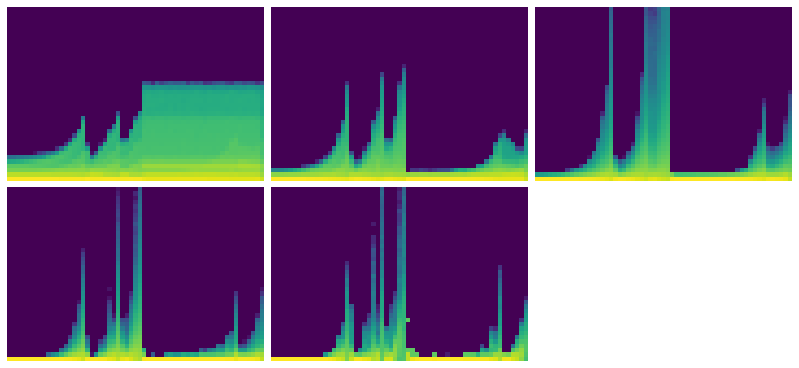

In [ ]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [ ]:
#| export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

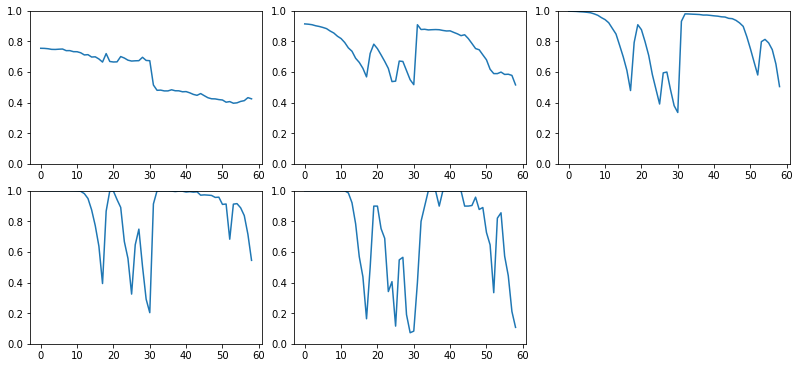

In [ ]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

## ActivationStats

In [ ]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [ ]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

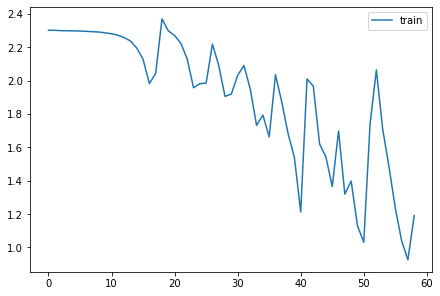

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

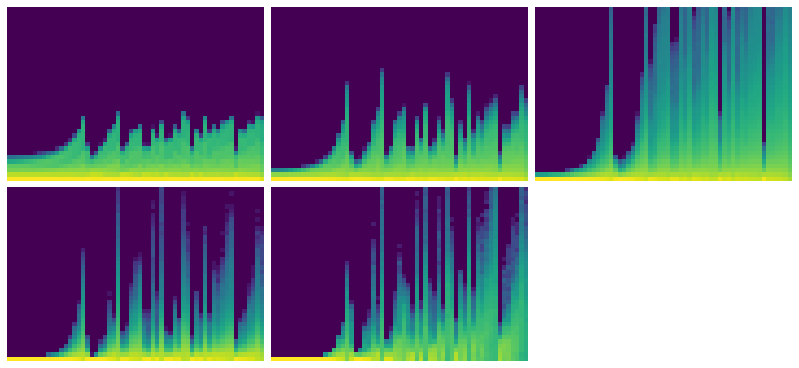

In [ ]:
astats.color_dim()

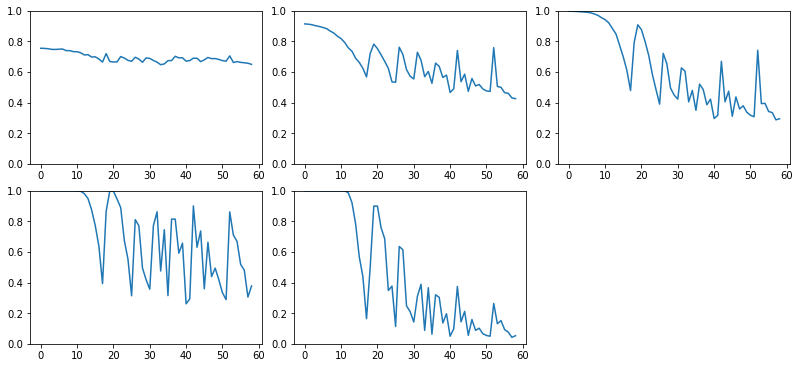

In [ ]:
astats.dead_chart()

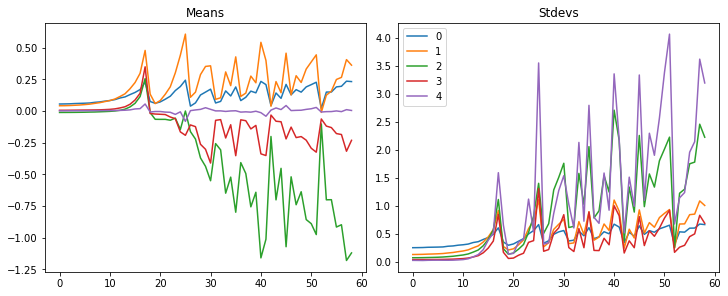

In [ ]:
astats.plot_stats()

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()